<a href="https://colab.research.google.com/github/RicoStaedeli/NLP2025_CQG/blob/main/5_Evaluation_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import userdata
import os

In [3]:
token = userdata.get('GITHUB')
repo_url = f"https://{token}@github.com/RicoStaedeli/NLP2025_CQG.git"

!git clone {repo_url}


os.chdir("NLP2025_CQG")
!ls

Cloning into 'NLP2025_CQG'...
remote: Enumerating objects: 928, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 928 (delta 125), reused 75 (delta 52), pack-reused 737 (from 2)
Receiving objects: 100% (928/928), 45.85 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (477/477), done.
Updating files: 100% (94/94), done.
1_Information_preprocessing.md	      Doc
1_Preprocessing.ipynb		      Evaluation
2_Baseline_Generation.ipynb	      INFORMATION.md
2_Information_Baseline_Generation.md  LICENSE
3_Evaluation.ipynb		      Logs
4_Finetuned_Generation.ipynb	      README.md
5_Evaluation_Analytics.ipynb	      requirements.txt
Data				      Training
Development			      Utils


In [4]:
import json

result_file = "results_Meta-Llama-3.1-1B-Instruct_SFT_2_eval"

with open(os.path.join(os.getcwd(), f"Evaluation/Scored/{result_file}.json"), "r", encoding="utf-8") as f:
    data = json.load(f)

In [5]:
import pandas as pd

rows = []
for entry_id, entry_data in data.items():
    context = entry_data['input']
    for cq in entry_data['cqs']:
        row = {
            "id": entry_id,
            "input": context,
            "schema": cq["schema"],
            "question": cq["cq"],
            "CauseToEffect": cq["CauseToEffect"],
            "ExpertOpinion": cq["ExpertOpinion"],
            "Analogy": cq["Analogy"],
            "FearAppeal": cq["FearAppeal"],
            "is_critical": cq["is_critical"],
        }
        rows.append(row)

df = pd.DataFrame(rows)

df.head()

,id,input,schema,question,CauseToEffect,ExpertOpinion,Analogy,FearAppeal,is_critical
0,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",CauseToEffect,Are there other factors in this particular cas...,1.0,0.0,3.5,3,False
1,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",ExpertOpinion,Is CLINTON a genuine expert in foreign policy?...,5.0,13.5,7.5,6,True
2,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",Analogy,Are CLINTON and CLINTON similar in the respect...,2.0,6.5,10.0,2,True
3,CLINTON_199_2,"CLINTON: ""which may prove to be an intelligenc...",FearAppeal,Is it practically possible for CLINTON to work...,2.0,0.0,3.0,3,False
4,CLINTON_1_2,"CLINTON: ""If you help create the profits , you...",CauseToEffect,How strong is the generalisation that if Clint...,6.0,2.0,7.5,3,False


In [7]:
percent_critical = (df['is_critical'].sum() / len(df)) * 100
print(percent_critical)

52.41935483870967


In [ ]:
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# 2. Group by schema to get total and critical counts
critical_summary = (
    df.groupby('schema')['is_critical']
    .agg(Total='count', Critical='sum')
    .reset_index()
)

# 3. Add accuracy as the proportion of critical questions
critical_summary['% Critical'] = (critical_summary['Critical'] / critical_summary['Total']) * 100

# 4. Compute schema score stats
score_stats = (
    df.groupby('schema')['schema_score']
    .agg(Average_Score='mean', Median_Score='median', Std_Dev='std', Min_Score='min', Max_Score='max')
    .reset_index()
)

# 5. Merge the two summaries
combined_summary = pd.merge(critical_summary, score_stats, on='schema')

# 6. Sort for readability
combined_summary = combined_summary.sort_values(by='Average_Score', ascending=False)

# Display
combined_summary

,schema,Total,Critical,% Critical,Average_Score,Median_Score,Std_Dev,Min_Score,Max_Score
2,ExpertOpinion,186,138,74.193548,9.395161,11.5,4.640134,0.0,13.5
0,Analogy,186,157,84.408602,8.185484,10.0,2.393517,0.0,10.0
1,CauseToEffect,186,66,35.483871,5.397849,6.0,2.892263,0.0,10.0
3,FearAppeal,186,29,15.591398,3.908602,3.0,2.073574,0.0,10.0


<ipython-input-9-017054efed9a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='schema', y='schema_score', data=df, palette='Set2')


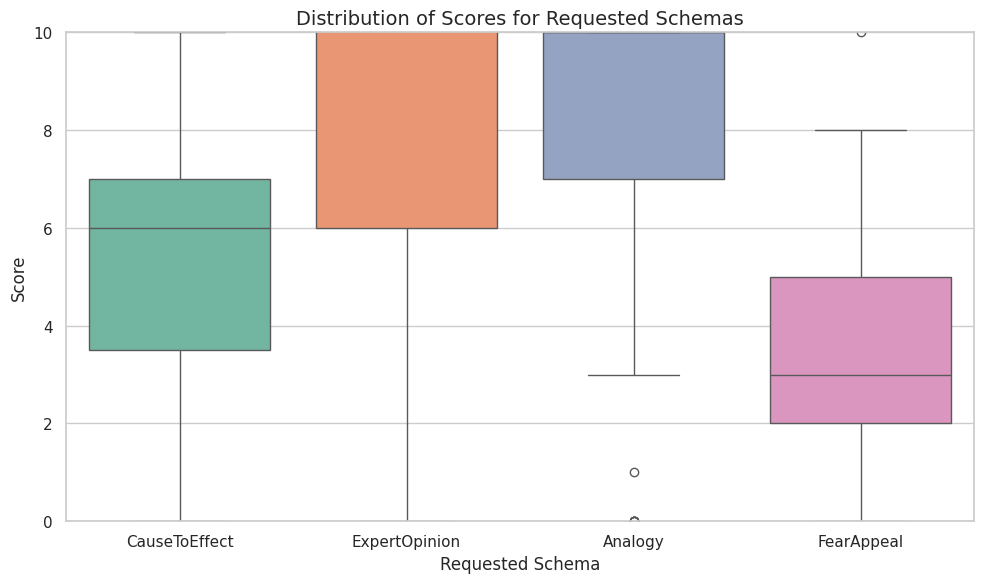

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure schema_score is computed
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# Set visual style
sns.set(style="whitegrid")

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='schema', y='schema_score', data=df, palette='Set2')

# Add titles and labels
plt.title('Distribution of Scores for Requested Schemas', fontsize=14)
plt.xlabel('Requested Schema')
plt.ylabel('Score')
plt.ylim(0, 10)
plt.tight_layout()
plt.show()

<ipython-input-10-7c1898fd55e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=score_counts.index.astype(int), y=score_counts.values, palette='viridis')


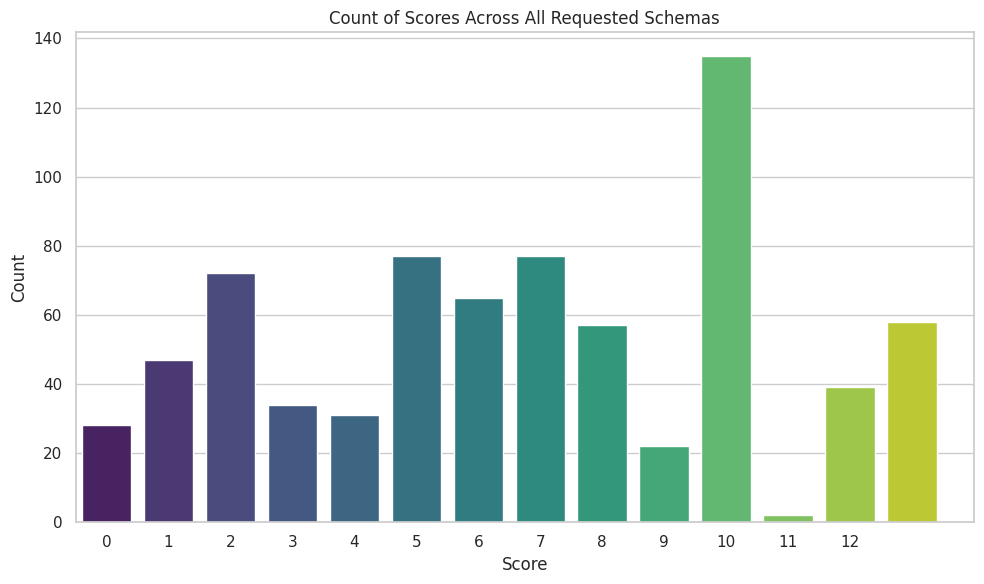

In [ ]:
# If not already done: Create 'schema_score' column (score for the requested schema)
df['schema_score'] = df.apply(lambda row: row[row['schema']], axis=1)

# Count the occurrences of each score (round if needed, assuming integer scores)
score_counts = df['schema_score'].round().value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=score_counts.index.astype(int), y=score_counts.values, palette='viridis')

plt.title('Count of Scores Across All Requested Schemas')
plt.xlabel('Score')
plt.ylabel('Count')
plt.xticks(score_counts.index.astype(int))
plt.tight_layout()
plt.show()

Count of questions per schema by is_critical:
is_critical    False  True 
schema                     
Analogy           29    157
CauseToEffect    120     66
ExpertOpinion     48    138
FearAppeal       157     29


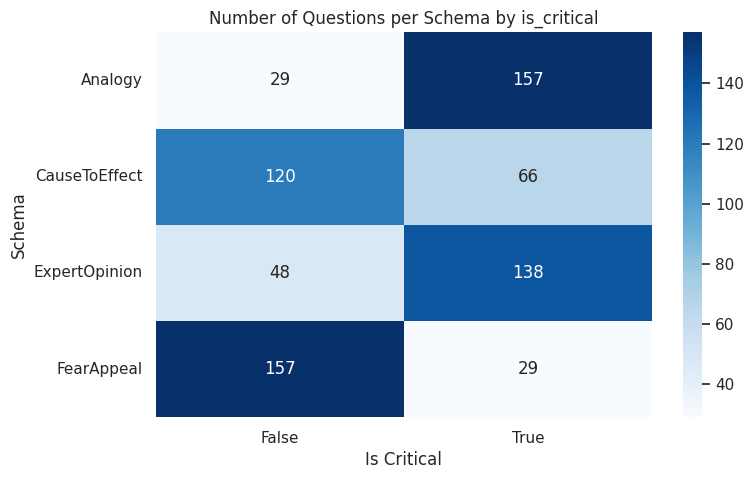

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

counts = pd.crosstab(df['schema'], df['is_critical'])

print("Count of questions per schema by is_critical:")
print(counts)

plt.figure(figsize=(8,5))
sns.heatmap(counts, annot=True, fmt='d', cmap='Blues')
plt.title('Number of Questions per Schema by is_critical')
plt.xlabel('Is Critical')
plt.ylabel('Schema')
plt.show()

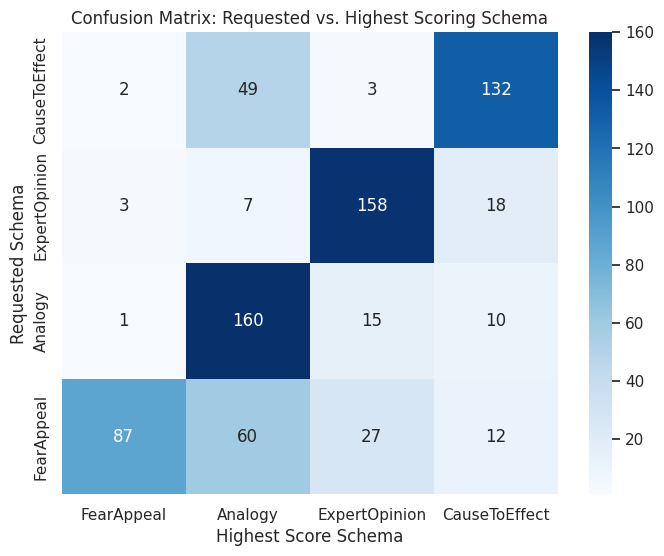

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix


# Original schema list
schemas = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']

# Find predicted schema by highest score
df['predicted_schema'] = df[schemas].idxmax(axis=1)

# Compute confusion matrix with original label order
cm = confusion_matrix(df['schema'], df['predicted_schema'], labels=schemas)

# Reverse the predicted schema order (columns)
reversed_schemas = schemas[::-1]

# Reorder columns of confusion matrix
cm_reversed = cm[:, ::-1]

# Plot confusion matrix with reversed predicted schema order
plt.figure(figsize=(8,6))
sns.heatmap(cm_reversed, annot=True, fmt='d', cmap='Blues',
            xticklabels=reversed_schemas, yticklabels=schemas)

plt.xlabel('Highest Score Schema')
plt.ylabel('Requested Schema')
plt.title('Confusion Matrix: Requested vs. Highest Scoring Schema')
plt.show()


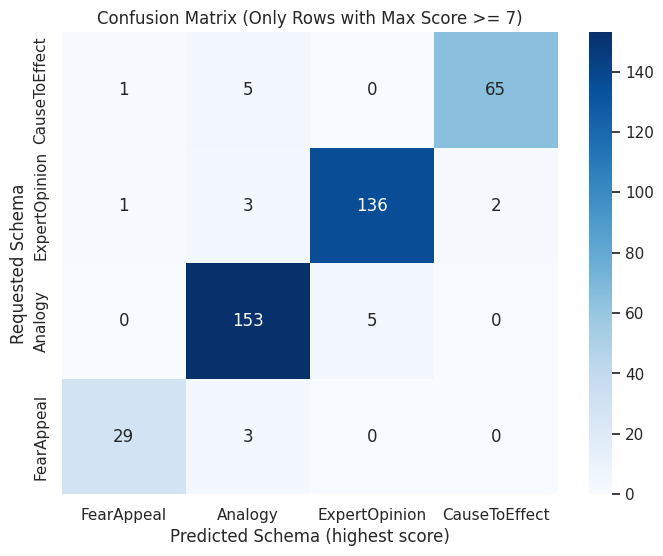

In [ ]:
# Assume df is your dataframe with columns:
# id, input, schema, question, CauseToEffect, ExpertOpinion, Analogy, FearAppeal, is_critical

# Find the highest score and which schema it belongs to
schema_cols = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']

# Find max score per row and corresponding predicted schema
df['max_score'] = df[schema_cols].max(axis=1)
df['predicted_schema'] = df[schema_cols].idxmax(axis=1)

# Filter to only rows where max_score >= 7
df_high_score = df[df['max_score'] >= 7]

# Create confusion matrix: actual requested schema vs predicted schema (highest scoring schema)
cm = confusion_matrix(df_high_score['schema'], df_high_score['predicted_schema'], labels=schema_cols)

# Reverse the order of predicted schema for nicer visualization (optional)
cm = cm[:, ::-1]

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=schema_cols[::-1],  # reversed order on x-axis
            yticklabels=schema_cols)
plt.xlabel('Predicted Schema (highest score)')
plt.ylabel('Requested Schema')
plt.title('Confusion Matrix (Only Rows with Max Score >= 7)')
plt.show()


In [ ]:
import pandas as pd

schema_cols = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']

def next_highest_schema(row):
    requested_schema = row['schema']
    requested_score = row[requested_schema]

    other_schemas = [s for s in schema_cols if s != requested_schema]
    other_scores = row[other_schemas]

    max_other_score = other_scores.max()
    max_other_schema = other_scores.idxmax()

    return pd.Series({'next_highest_schema': max_other_schema, 'next_highest_score': max_other_score, 'requested_score': requested_score})

# Apply function row-wise
df_next_highest = df.apply(next_highest_schema, axis=1)

# Combine with original df
df_combined = pd.concat([df, df_next_highest], axis=1)

# Now group by 'schema' and aggregate:
summary = df_combined.groupby('schema').agg(
    count=('id', 'size'),
    avg_requested_score=('requested_score', 'mean'),
    avg_next_highest_score=('next_highest_score', 'mean'),
    most_common_next_schema=('next_highest_schema', lambda x: x.mode()[0])
).reset_index()

print(summary)


          schema  count  avg_requested_score  avg_next_highest_score  \
0        Analogy    186             8.185484                5.811828   
1  CauseToEffect    186             5.397849                4.559140   
2  ExpertOpinion    186             9.395161                6.438172   
3     FearAppeal    186             3.908602                3.204301   

  most_common_next_schema  
0           ExpertOpinion  
1                 Analogy  
2                 Analogy  
3                 Analogy  


In [ ]:
import pandas as pd

schema_cols = ['CauseToEffect', 'ExpertOpinion', 'Analogy', 'FearAppeal']

def next_highest_schema(row):
    requested_schema = row['schema']
    other_schemas = [s for s in schema_cols if s != requested_schema]
    other_scores = row[other_schemas]
    max_other_schema = other_scores.idxmax()
    return max_other_schema

# Apply function to find the schema with highest *next* score for each row
df['next_highest_schema'] = df.apply(next_highest_schema, axis=1)

# Create a crosstab / confusion matrix: rows=requested schema, columns=next highest schema counts
matrix = pd.crosstab(df['schema'], df['next_highest_schema'])

print(matrix)


next_highest_schema  Analogy  CauseToEffect  ExpertOpinion  FearAppeal
schema                                                                
Analogy                    0             13            169           4
CauseToEffect            159              0              8          19
ExpertOpinion            129             38              0          19
FearAppeal               126             30             30           0


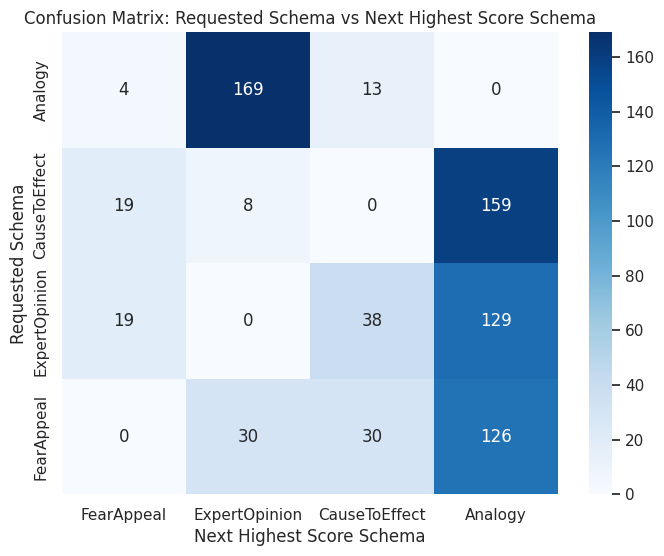

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(matrix[matrix.columns[::-1]], annot=True, fmt='d', cmap='Blues',
            xticklabels=matrix.columns[::-1],
            yticklabels=matrix.index)

plt.xlabel('Next Highest Score Schema')
plt.ylabel('Requested Schema')
plt.title('Confusion Matrix: Requested Schema vs Next Highest Score Schema')
plt.show()
